# Random Forest Sweep - Baseline Model

## Imports & Data Preparation

In [83]:
import numpy as np
import pandas as pd
import pickle
import os

from kneed import KneeLocator

import statsmodels.api as sm
from sklearn import linear_model, neural_network
from sklearn import model_selection, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.pyplot as plt

In [84]:
def load_data():
  #paths = ["2011-2012.pkl", "2012-2013.pkl", "2013-2014.pkl", "2014-2015.pkl", "2015-2016.pkl"]
  paths = ["2007-2008.pkl", "2008-2009.pkl", "2009-2010.pkl"]
  game_data_path = "../data/neural_net_data/"
  files = os.listdir(game_data_path)


  years = []

  for path in paths:
    with open(game_data_path + path, 'rb') as f:
      curr_X, curr_y = pickle.load(f, encoding='latin1')
      print(curr_X.shape, curr_y.shape)

    curr_X = curr_X.reshape(curr_X.shape[0], -1)
    years.append((curr_X, curr_y))
    
  return years

In [86]:
# CHANGE AS NEEDED
data = load_data()

X_list = []
y_list = []

for i, (X, y) in enumerate(data):
    print(f"Before reshape - Year {i}: X = {X.shape}, y = {y.shape}")
    X = X.reshape(X.shape[0], -1)  # Flatten 3D (N, 3, 508) -> 2D (N, 1524)
    year_feature = np.full((X.shape[0], 1), i+2010)
    X = np.hstack([X, year_feature])
    X_list.append(X)
    y_list.append(y)

#X_train = np.vstack(X_list[0:len(X_list)-2])
#y_train = np.concatenate(y_list[0:len(y_list)-2])  # For 1D target vectors

X_train = X_list[0]
y_train = y_list[0]
X_val = X_list[1]
y_val = y_list[1]
X_test = X_list[2]
y_test = y_list[2]

X_train.shape
X_val.shape
X_test.shape

(1267, 3, 508) (1267,)
(1266, 3, 508) (1266,)
(1263, 3, 508) (1263,)
Before reshape - Year 0: X = (1267, 1524), y = (1267,)
Before reshape - Year 1: X = (1266, 1524), y = (1266,)
Before reshape - Year 2: X = (1263, 1524), y = (1263,)


(1263, 1525)

## Random Forest

In [90]:
# DEFAULT PARAMS
test_depth = 6
test_tree_count = 150
test_state = 2

### Depth Sweep

In [91]:
depths = [1,2,3,4,5,7,10,15]
depth_mse = []
depth_variance = []

for depth in depths:
  model = RandomForestRegressor(n_estimators=test_tree_count, max_depth=depth, random_state=test_state)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)
  curr_MSE = metrics.mean_squared_error(y_val, y_pred)
  depth_mse.append(curr_MSE)
  curr_variance = metrics.r2_score(y_val, y_pred)
  depth_variance.append(curr_variance)
  
  print("At a depth of {}".format(depth))
  print("MSE: %.3f" % curr_MSE)
  print("Variance: %.3f" % curr_variance)
  print("-----")
  
best_depth = depths[depth_mse.index(min(depth_mse))]
print("Best Depth: {}".format(best_depth))
print("-----")

At a depth of 1
MSE: 811.993
Variance: -0.028
-----
At a depth of 2
MSE: 831.367
Variance: -0.053
-----
At a depth of 3
MSE: 849.485
Variance: -0.075
-----
At a depth of 4
MSE: 870.216
Variance: -0.102
-----


KeyboardInterrupt: 

### Num Trees Sweep

In [89]:
num_trees = [20, 50, 100, 150, 200, 250]
tree_train_mse = []
tree_val_mse = []
tree_variance = []

for tree_count in num_trees:

  model = RandomForestRegressor(n_estimators=tree_count, max_depth=4, random_state=test_state)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)
  y_train_pred = model.predict(X_train)
  print(y_train_pred.shape, y_pred.shape, X_train.shape, X_val.shape)
  curr_train_MSE = metrics.mean_squared_error(y_train_pred, y_train)
  tree_train_mse.append(curr_MSE)
  curr_val_MSE = metrics.mean_squared_error(y_val, y_pred)
  tree_val_mse.append(curr_MSE)
  curr_variance = metrics.r2_score(y_val, y_pred)
  tree_variance.append(curr_variance)
  
  print("At a tree count of {}".format(tree_count))
  print("Train MSE: %.3f" % curr_train_MSE)
  print("Val MSE: %.3f" % curr_val_MSE)
  print("Variance: %.3f" % curr_variance)
  print("-----")
best_num_trees = max(tree_train_mse, tree_val_mse)
# knee = KneeLocator(num_trees, tree_val_mse, curve='convex', direction='decreasing')
# best_num_trees = knee.knee
# if best_num_trees == None:
#   best_num_trees = num_trees[len(num_trees)//2]
print("Best Tree Num: {}".format(best_num_trees))
print("-----")

(1267,) (1266,) (1267, 1525) (1266, 1525)
At a tree count of 20
Train MSE: 1039.618
Val MSE: 904.294
Variance: -0.145
-----
(1267,) (1266,) (1267, 1525) (1266, 1525)
At a tree count of 50
Train MSE: 1038.909
Val MSE: 883.380
Variance: -0.118
-----
(1267,) (1266,) (1267, 1525) (1266, 1525)
At a tree count of 100
Train MSE: 1026.512
Val MSE: 874.509
Variance: -0.107
-----
(1267,) (1266,) (1267, 1525) (1266, 1525)
At a tree count of 150
Train MSE: 1018.962
Val MSE: 870.216
Variance: -0.102
-----
(1267,) (1266,) (1267, 1525) (1266, 1525)
At a tree count of 200
Train MSE: 1020.826
Val MSE: 872.775
Variance: -0.105
-----


KeyboardInterrupt: 

## Best Case Sweep

In [93]:
model = RandomForestRegressor(n_estimators=150, max_depth=1, random_state=test_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
final_train_mse = metrics.mean_squared_error(y_train, y_pred)
final_train_variance = metrics.r2_score(y_train, y_pred)
print("Train MSE: %.3f" % final_train_mse)
print("Train Variance: %.3f" % final_train_variance)
print("-----")

y_pred = model.predict(X_val)
final_val_mse = metrics.mean_squared_error(y_val, y_pred)
final_val_variance = metrics.r2_score(y_val, y_pred)
print("Val MSE: %.3f" % final_val_mse)
print("Val Variance: %.3f" % final_val_variance)
print("-----")

y_pred = model.predict(X_test)
final_test_mse = metrics.mean_squared_error(y_test, y_pred)
final_test_variance = metrics.r2_score(y_test, y_pred)
print("Test MSE: %.3f" % final_test_mse)
print("Test Variance: %.3f" % final_test_variance)
print("-----")

Train MSE: 1280.877
Train Variance: 0.090
-----
Val MSE: 811.993
Val Variance: -0.028
-----
Test MSE: 5178.903
Test Variance: -2.726
-----


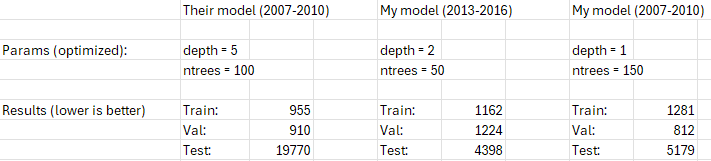